# California Housing Dataset


The California Housing dataset originates from the 1990 U.S. Census. Each observation represents a census block group. The dataset contains 20,640 observations with no missing values. 

The key research question is:

*"What is the influencing factors of the median house value in a census block group?"*

## Data Source

The dataset is built into scikit-learn and can be loaded directly without downloading:
```python
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame
```

## Variables

| Variable | Type | Description |
|---|---|---|
| `MedHouseVal` | Dependent (Y) | Median house value in block group (units: $100,000) |
| `MedInc` | Socioeconomic | Median household income in block group (units: tens of thousands of dollars) |
| `HouseAge` | Housing stock | Median age of houses in block group (years) |
| `AveRooms` | Housing stock | Average number of rooms per household |
| `AveBedrms` | Housing stock | Average number of bedrooms per household |
| `Population` | Demographic | Total population of block group |
| `AveOccup` | Demographic | Average number of occupants per household |
| `Latitude` | Location | Block group centroid latitude |
| `Longitude` | Location | Block group centroid longitude |


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import KNN
from libpysal.weights import lag_spatial
from esda.moran import Moran
from spreg import OLS, ML_Error, ML_Lag
from scipy import stats
from splot.esda import moran_scatterplot, plot_moran

import contextily as ctx
import pyproj
from matplotlib.ticker import FuncFormatter

In [5]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame

print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")
df.head()

Dataset shape: (20640, 9)
Missing values:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


---
## 1. Data Cleaning


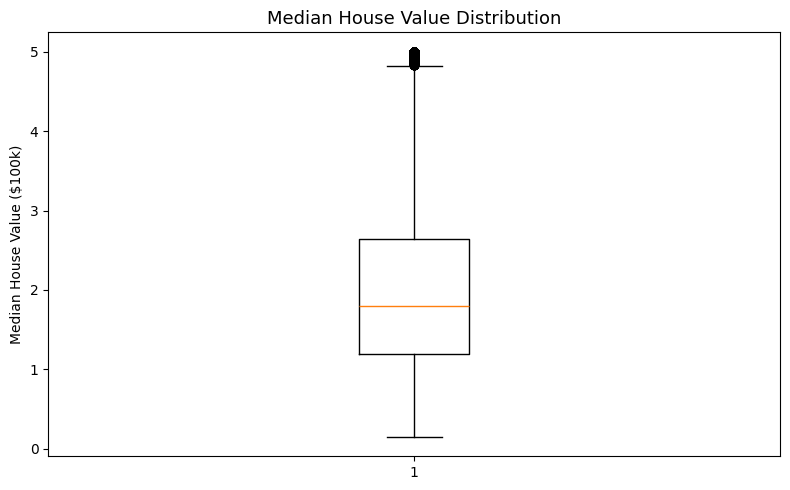

In [6]:
# Check for extreme values
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(df['MedHouseVal'], vert=True)
ax.set_title('Median House Value Distribution', fontsize=13)
ax.set_ylabel('Median House Value ($100k)')
plt.tight_layout()
plt.show()

In [8]:
# ---- Remove capped values ----
# MedHouseVal is capped at 5.00001 ($500,001) — these are censored observations
print(f"Capped values (MedHouseVal >= 5.0): {(df['MedHouseVal'] >= 5.0).sum()}")
df_clean = df[df['MedHouseVal'] < 5.0].copy()
print(f"After removing capped values: {len(df_clean)}")

Capped values (MedHouseVal >= 5.0): 992
After removing capped values: 19648


In [9]:
# ---- Sample for computational feasibility ----
# Spatial regression with ML estimation on 20k+ points is very slow
# We sample 2000 observations for this exercise
np.random.seed(42)
df_clean = df_clean.sample(n=2000, random_state=42).reset_index(drop=True)
print(f"After sampling: {len(df_clean)}")

# ---- Log-transform dependent variable ----
df_clean['log_MedHouseVal'] = np.log(df_clean['MedHouseVal'])

print(f"\nFinal dataset: {df_clean.shape}")
df_clean.describe().round(3)

After sampling: 2000

Final dataset: (2000, 10)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,log_MedHouseVal
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,3.669,28.462,5.316,1.093,1412.893,2.968,35.552,-119.464,1.916,0.519
std,1.544,12.476,1.858,0.319,990.965,0.974,2.129,1.981,0.971,0.525
min,0.500,2.000,1.550,0.375,5.000,0.971,32.550,-124.230,0.150,-1.897
25%,2.564,18.000,4.380,1.007,794.000,2.439,33.920,-121.550,1.185,0.170
50%,3.429,28.000,5.170,1.049,1171.500,2.836,34.210,-118.430,1.708,0.535
75%,4.562,37.000,5.944,1.100,1754.000,3.337,37.660,-117.990,2.452,0.897
max,15.000,52.000,33.990,6.825,10475.000,19.312,41.800,-114.470,4.964,1.602


---
## 2. Exploratory Analysis

In [15]:
transformer = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

def lon_formatter(x, pos):
    lon, _ = transformer.transform(x, 0)
    return f'{lon:.2f}°'

def lat_formatter(y, pos):
    _, lat = transformer.transform(0, y)
    return f'{lat:.2f}°'

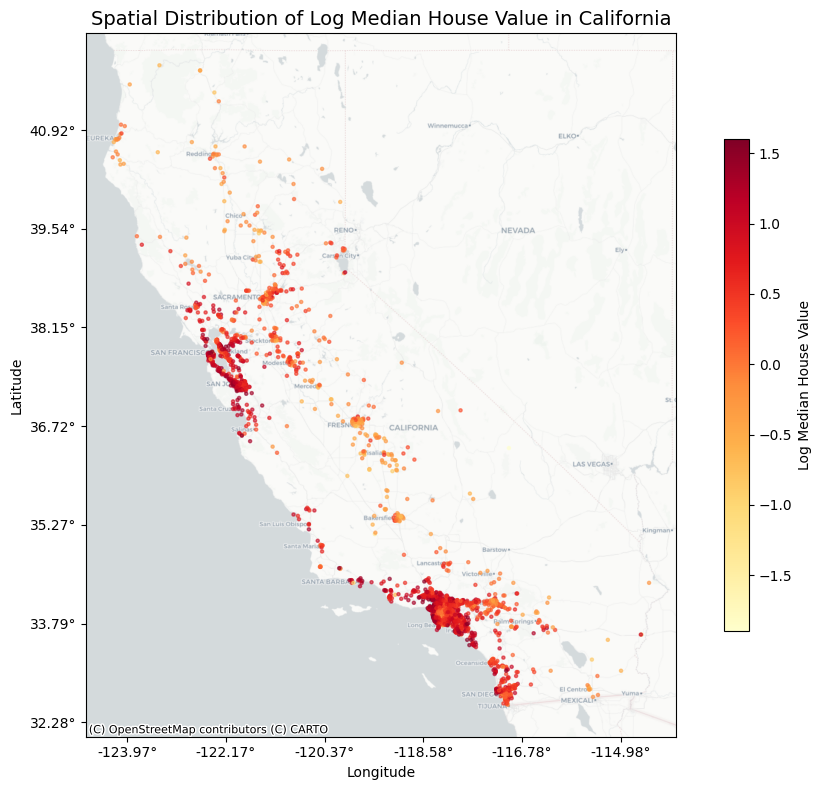

In [16]:
geometry = [Point(xy) for xy in zip(df_clean['Longitude'], df_clean['Latitude'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')
gdf_web = gdf.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(10, 8))

gdf_web.plot(
    ax=ax, column='log_MedHouseVal', cmap='YlOrRd',
    markersize=5, alpha=0.6, legend=True,
    legend_kwds={'label': 'Log Median House Value', 'shrink': 0.7}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Spatial Distribution of Log Median House Value in California', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

plt.tight_layout()
plt.show()

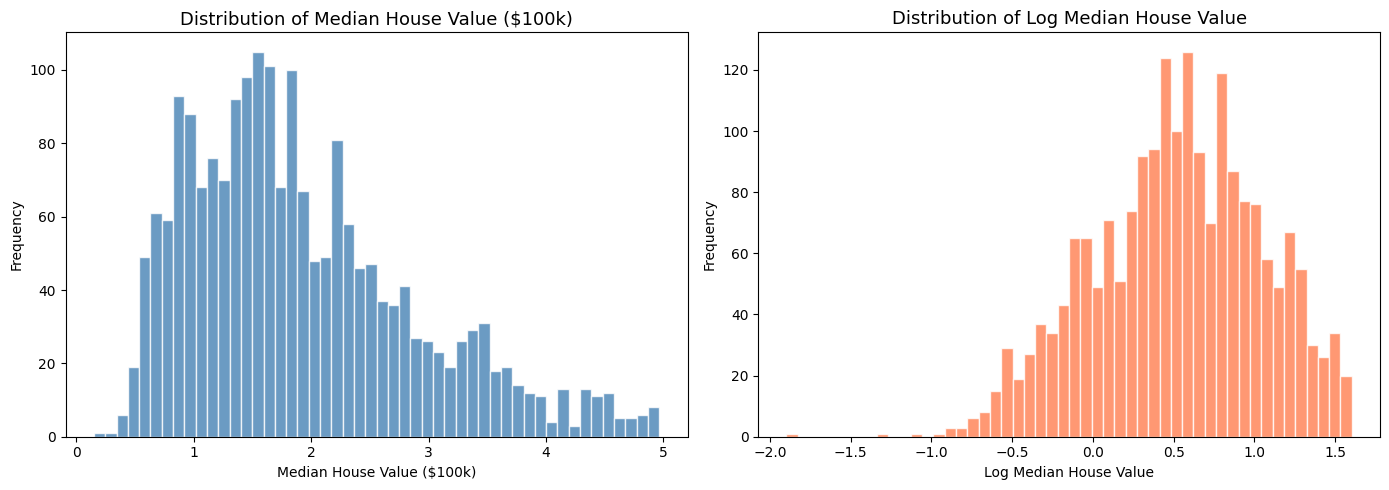

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['MedHouseVal'], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_title('Distribution of Median House Value ($100k)', fontsize=13)
axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_clean['log_MedHouseVal'], bins=50, color='coral', edgecolor='white', alpha=0.8)
axes[1].set_title('Distribution of Log Median House Value', fontsize=13)
axes[1].set_xlabel('Log Median House Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


---
## 3. Constructing the Spatial Weight Matrix

In [18]:
# ---- Step 1: Project to a metric CRS for distance calculations ----
# KNN needs coordinates in metres, not degrees
# UTM Zone 10N covers most of California
gdf_proj = gdf.to_crs('EPSG:32610')

# ---- Step 2: Extract projected x, y coordinates as a numpy array ----
coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))

# ---- Step 3: Build KNN weight matrix (k=5) ----
# Each observation is connected to its 5 nearest neighbours
w_knn = KNN.from_array(coords, k=5)

# ---- Step 4: Row-standardise ----
# Each row sums to 1, so Wy gives a weighted average of neighbours
w_knn.transform = 'R'


---
## 4. OLS Regression


In [20]:

y_col = 'log_MedHouseVal'
y = df_clean[[y_col]].values

x_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 
          'Population', 'AveOccup']

x = df_clean[x_cols].values


In [21]:
ols = OLS(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='California Housing',
    spat_diag=True
)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :California Housing
Weights matrix      :     unknown
Dependent Variable  :log_MedHouseVal                Number of Observations:        2000
Mean dependent var  :      0.5195                Number of Variables   :           7
S.D. dependent var  :      0.5249                Degrees of Freedom    :        1993
R-squared           :      0.4965
Adjusted R-squared  :      0.4950
Sum squared residual:     277.302                F-statistic           :    327.6102
Sigma-square        :       0.139                Prob(F-statistic)     :  1.236e-292
S.E. of regression  :       0.373                Log likelihood        :    -862.080
Sigma-square ML     :       0.139                Akaike info criterion :    1738.161
S.E of regression ML:      0.3724                Schwarz criterion     :    1777.367

---------------------------------------------------

In [22]:
# Moran's I test for spatial autocorrelation in OLS residuals
residuals = ols.u.flatten()
moran = Moran(residuals, w_knn)

print("=== Global Moran's I Test on OLS Residuals ===")
print(f"Moran's I:     {moran.I:.4f}")
print(f"Expected I:    {moran.EI:.4f}")
print(f"Z-score:       {moran.z_sim:.4f}")
print(f"P-value:       {moran.p_sim:.4f}")
print()


=== Global Moran's I Test on OLS Residuals ===
Moran's I:     0.4197
Expected I:    -0.0005
Z-score:       31.7374
P-value:       0.0010



---
## 8. Spatial Regression Models

As all LM tests are significant, we estimate SDM

In [23]:
# Create spatially lagged X variables (WX)
wx_cols = ['W_' + col for col in x_cols]
wx_array = np.column_stack([lag_spatial(w_knn, x[:, i]) for i in range(x.shape[1])])

# Combine X and WX
x_sdm = np.hstack([x, wx_array])
x_sdm_names = x_cols + wx_cols

In [24]:
# Estimate SDM as ML_Lag with both X and WX
sdm = ML_Lag(
    y, x_sdm,
    w=w_knn,
    name_y=y_col,
    name_x=x_sdm_names,
    name_ds='California Housing (SDM)'
)

print(sdm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :California Housing (SDM)
Weights matrix      :     unknown
Dependent Variable  :log_MedHouseVal                Number of Observations:        2000
Mean dependent var  :      0.5195                Number of Variables   :          14
S.D. dependent var  :      0.5249                Degrees of Freedom    :        1986
Pseudo R-squared    :      0.7945
Spatial Pseudo R-squared:  0.6941
Log likelihood      :    -55.8943
Sigma-square ML     :      0.0568                Akaike info criterion :     139.789
S.E of regression   :      0.2383                Schwarz criterion     :     218.201

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------

LR test to explore if SDM can be simplfied 

In [25]:
# Spatial Error Model (Maximum Likelihood)
sem = ML_Error(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='California Housing'
)

print(sem.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :California Housing
Weights matrix      :     unknown
Dependent Variable  :log_MedHouseVal                Number of Observations:        2000
Mean dependent var  :      0.5195                Number of Variables   :           7
S.D. dependent var  :      0.5249                Degrees of Freedom    :        1993
Pseudo R-squared    :      0.2940
Log likelihood      :   -181.4199
Sigma-square ML     :      0.0588                Akaike info criterion :     376.840
S.E of regression   :      0.2425                Schwarz criterion     :     416.046

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.

In [26]:
# Spatial Lag Model (Maximum Likelihood)
sar = ML_Lag(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='California Housing'
)

print(sar.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :California Housing
Weights matrix      :     unknown
Dependent Variable  :log_MedHouseVal                Number of Observations:        2000
Mean dependent var  :      0.5195                Number of Variables   :           8
S.D. dependent var  :      0.5249                Degrees of Freedom    :        1992
Pseudo R-squared    :      0.7626
Spatial Pseudo R-squared:  0.5154
Log likelihood      :   -217.0398
Sigma-square ML     :      0.0658                Akaike info criterion :     450.080
S.E of regression   :      0.2565                Schwarz criterion     :     494.887

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------

In [27]:
# ---- Likelihood Ratio Tests ----
print("=" * 60)
print("LIKELIHOOD RATIO (LR) TESTS")
print("=" * 60)

# LR Test 1: SDM vs SAR (H0: theta = 0)
lr_sdm_sar = -2 * (sar.logll - sdm.logll)
df_diff_sar = len(x_cols)
p_sdm_sar = 1 - stats.chi2.cdf(lr_sdm_sar, df_diff_sar)

print(f"\nLR Test: SDM vs SAR")
print(f"  H0: theta = 0 (spatially lagged X variables are unnecessary)")
print(f"  LR statistic: {lr_sdm_sar:.4f}")
print(f"  Degrees of freedom: {df_diff_sar}")
print(f"  P-value: {p_sdm_sar:.4f}")
if p_sdm_sar < 0.05:
    print("  -> Reject H0: SDM is preferred over SAR")
else:
    print("  -> Cannot reject H0: SAR is sufficient")

# LR Test 2: SDM vs SEM
lr_sdm_sem = -2 * (sem.logll - sdm.logll)
df_diff_sem = len(x_cols) + 1
p_sdm_sem = 1 - stats.chi2.cdf(lr_sdm_sem, df_diff_sem)

print(f"\nLR Test: SDM vs SEM")
print(f"  H0: theta + rho*beta = 0 (common factor hypothesis)")
print(f"  LR statistic: {lr_sdm_sem:.4f}")
print(f"  Degrees of freedom: {df_diff_sem}")
print(f"  P-value: {p_sdm_sem:.4f}")
if p_sdm_sem < 0.05:
    print("  -> Reject H0: SDM is preferred over SEM")
else:
    print("  -> Cannot reject H0: SEM is sufficient")

# Final recommendation
print("\n" + "=" * 60)
print("FINAL MODEL RECOMMENDATION")
print("=" * 60)
if p_sdm_sar < 0.05 and p_sdm_sem < 0.05:
    print("-> SDM is preferred: Both SAR and SEM are rejected in favour of SDM.")
elif p_sdm_sar >= 0.05 and p_sdm_sem < 0.05:
    print("-> SAR is preferred: SDM does not significantly improve over SAR.")
elif p_sdm_sar < 0.05 and p_sdm_sem >= 0.05:
    print("-> SEM is preferred: SDM does not significantly improve over SEM.")
else:
    print("-> Either SAR or SEM may be sufficient. Choose based on AIC and theory.")


LIKELIHOOD RATIO (LR) TESTS

LR Test: SDM vs SAR
  H0: theta = 0 (spatially lagged X variables are unnecessary)
  LR statistic: 322.2909
  Degrees of freedom: 6
  P-value: 0.0000
  -> Reject H0: SDM is preferred over SAR

LR Test: SDM vs SEM
  H0: theta + rho*beta = 0 (common factor hypothesis)
  LR statistic: 251.0512
  Degrees of freedom: 7
  P-value: 0.0000
  -> Reject H0: SDM is preferred over SEM

FINAL MODEL RECOMMENDATION
-> SDM is preferred: Both SAR and SEM are rejected in favour of SDM.
